<a href="https://colab.research.google.com/github/Tarandeep97/Kaggle-EarthQuake-Prediction/blob/master/Kaggle_Earthquake_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [EarthQuake Prediction Challenge](https://www.kaggle.com/c/LANL-Earthquake-Prediction)

## Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.![alt text](http://getwallpapers.com/wallpaper/full/3/6/0/830812-full-size-earthquake-wallpapers-2048x1366.jpg)

## Data Description:

The acoustic_data input signal is used to predict the time remaining before the next laboratory earthquake (time_to_failure).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file. 

# Install & import dependencies

In [1]:
!pip install kaggle

!pip install numpy

In [0]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import GridSearchCV

from sklearn.svm import NuSVR, SVR

from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt


# Import Kaggle Dataset

In [3]:
from google.colab import files


uploaded = files.upload()


for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [4]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3036           False  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11388            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4690            True  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         38           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3238           False  
champs-scalar-coupling                             2019-08-28 23:59:00  Featured           $30,000      

In [5]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 31.0MB/s]
 96% 232M/242M [00:02<00:00, 129MB/s]
100% 242M/242M [00:02<00:00, 111MB/s]
100% 2.03G/2.03G [00:37<00:00, 34.4MB/s]
100% 2.03G/2.03G [00:37<00:00, 58.4MB/s]


In [6]:
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


# Exploratory Data Analysis

In [0]:
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data' : np.int16, 'time_to_failure':np.float64})

In [8]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


#  Feature Engineering

In [0]:
def gen_features(X):
  strain=[]
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(np.quantile(X, 0.01))
  
  return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [12]:
X_train.describe()

,0,1,2,3,4,5
count,3663.000000,3663.000000,3663.000000,3663.000000,3663.000000,3663.000000
mean,4.558681,6.475079,-146.630358,67.440017,0.125667,-11.061474
std,0.232746,8.464218,261.467967,69.567123,0.477765,14.372707
min,3.798020,2.802720,-5515.000000,0.648602,-4.091826,-336.000000
25%,4.392703,4.463993,-152.000000,27.667049,-0.038608,-13.000000
50%,4.553893,5.539752,-109.000000,45.131461,0.086415,-10.000000
75%,4.715770,6.801470,-79.000000,77.681078,0.250444,-6.000000
max,5.391993,153.703569,-15.000000,631.158927,4.219429,-2.000000


#  Learning Model Implementation



1.   SUPPORT VECTOR MACHINES
2.   KERNEL RIDGE





In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.3685
{'C': 2, 'gamma': 0.1}


In [19]:
parameters = [{'gamma': np.linspace(0.001, 0.1, 10),
               'alpha': [0.005, 0.01, 0.02, 0.05, 0.1]}]

reg2 = GridSearchCV(KernelRidge(kernel='rbf'), parameters, cv=5, scoring='neg_mean_absolute_error')
reg2.fit(X_train_scaled, y_train.values.flatten())
y_pred2 = reg2.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg2.best_score_))
print(reg2.best_params_)

Best CV score: -2.3088
{'alpha': 0.02, 'gamma': 0.034}


# Graphical Analysis of Model Performance 


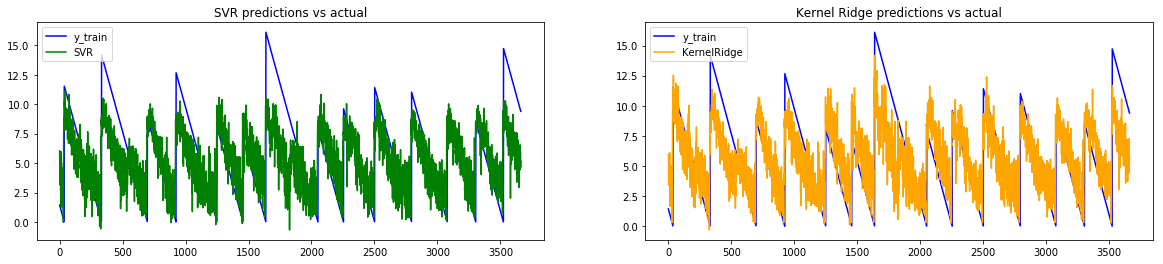

In [35]:
f = plt.figure(figsize=(20, 4))
f.add_subplot(1, 2, 1)
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred1, color='green', label='SVR')
plt.legend()
plt.title('SVR predictions vs actual')

f.add_subplot(1, 2, 2)
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred2, color='orange', label='KernelRidge')
plt.legend()
plt.title('Kernel Ridge predictions vs actual')
plt.show()

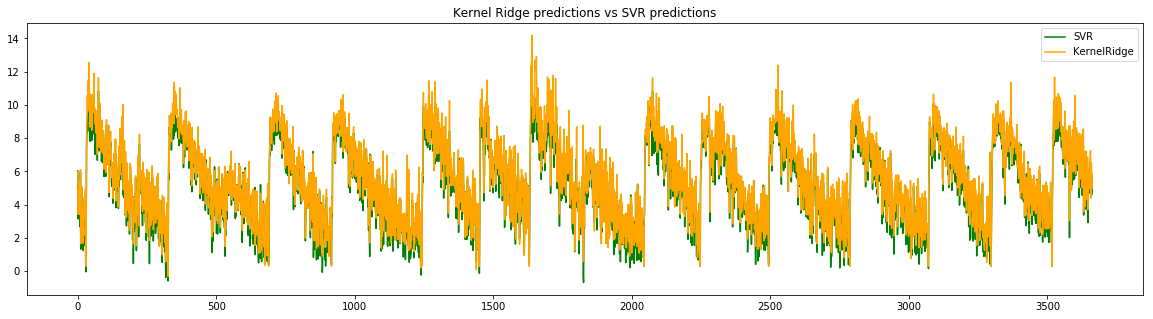

In [37]:
plt.figure(figsize=(20, 5))
plt.plot(y_pred1, color='green', label='SVR')
plt.plot(y_pred2, color='orange', label='KernelRidge')
plt.legend()
plt.title('Kernel Ridge predictions vs SVR predictions')
plt.show()